In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import seaborn as sns
from shapely import wkt
from shapely.geometry import Point
import networkx as nx
import osmnx as ox
import yaml
from transportation_metrics import load_census_block_group_shapefile, load_school_data, load_slow_streets_data
ox.config(use_cache=True, log_console=True)

/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1dev-CAPI-1.14.1) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


2022-02-22 20:07:31 Configured OSMnx 1.0.1
2022-02-22 20:07:31 HTTP response caching is on
2022-02-22 20:07:31 Configured OSMnx 1.0.1
2022-02-22 20:07:31 HTTP response caching is on


In [3]:
muni_routes = gpd.read_file("/Users/katherinementzer/Downloads/Muni_Simple_Routes.csv")
muni_routes['geometry'] = muni_routes['shape'].apply(wkt.loads)
muni_routes = muni_routes.set_crs('epsg:4326').to_crs('epsg:3857')

In [4]:
census = load_census_block_group_shapefile()
sc_df = load_school_data()

In [91]:
muni = muni_routes.drop_duplicates()
muni = muni.loc[muni.DIRECTION == 'I'].loc[muni.SERVICE_CA.isin(['Frequent', 'Rapid Bus', 'Muni Metro'])]

<AxesSubplot:>

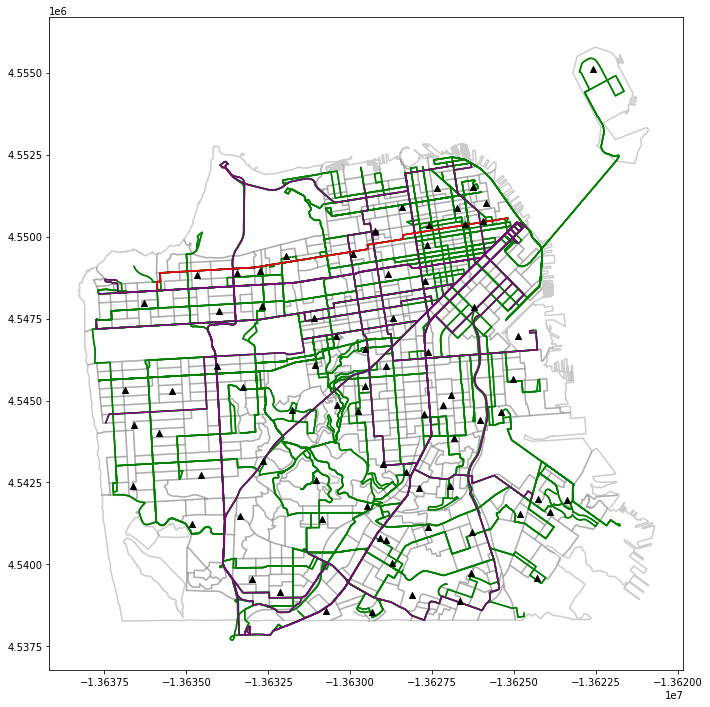

In [93]:
plt.figure(figsize=(12,12))
ax = plt.gca()
census.boundary.plot(ax=ax, color='gray', alpha=0.4)
sc_df.plot(ax=ax, c='black', marker='^', zorder=50)
muni_routes.plot(ax=ax, color='green')
muni.plot(ax=ax, color='purple')
muni.head(1).plot(ax=ax, color='red')
# slow_streets.plot(ax=ax, color='purple')
# bike_routes[bike_routes.geometry.contains(bike_routes.geometry[7])].dissolve().plot(ax=ax, color='red')

In [94]:
buffered = muni.copy()
buffered.geometry = buffered.geometry.buffer(402)
muni_poly = buffered.dissolve()

<AxesSubplot:>

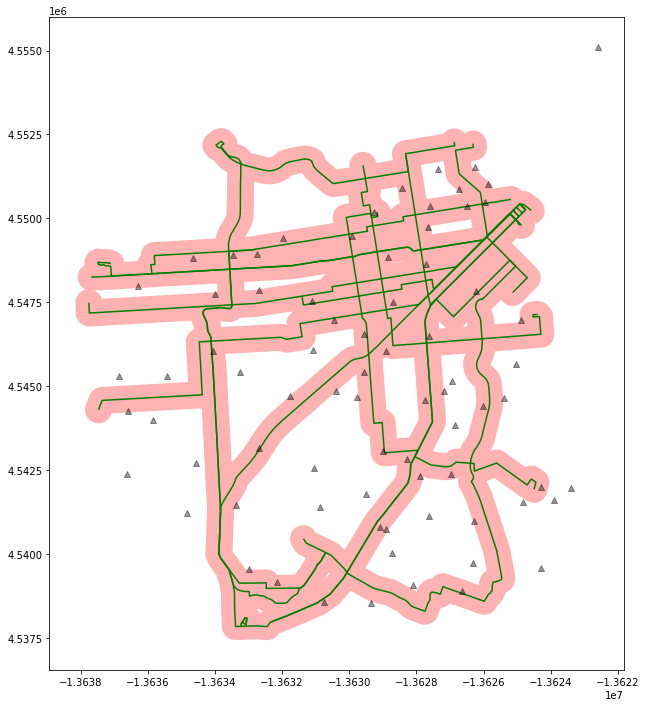

In [95]:
plt.figure(figsize=(12,12))
ax = plt.gca()
# census.boundary.plot(ax=ax, color='gray', alpha=0.4)
# relevant_blocks.boundary.plot(ax=ax, color='gray', alpha=0.4)
sc_df.plot(ax=ax, c='black', marker='^', zorder=50, alpha=0.4)
muni.plot(ax=ax, color='green')
muni_poly.plot(ax=ax, color='red', alpha=0.3)
# sc_df.sjoin(bike_poly).plot(ax=ax, marker='^', c='black', zorder=50)

In [25]:
geom1= muni.head(1).geometry
# for x in muni.geometry:
print(muni.geometry.crosses(geom1))

1      False
6      False
8      False
14     False
20     False
22     False
23     False
28     False
33     False
36     False
41     False
44     False
49     False
54     False
56     False
61     False
65     False
68     False
72     False
78     False
81     False
84     False
85     False
94     False
96     False
101    False
105    False
109    False
112    False
117    False
123    False
129    False
133    False
135    False
136    False
140    False
143    False
146    False
151    False
154    False
156    False
161    False
165    False
169    False
172    False
176    False
180    False
186    False
188    False
194    False
196    False
201    False
dtype: bool


/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


In [60]:
type(small_buffered.loc[1,'geometry'])

shapely.geometry.polygon.Polygon

In [97]:
small_buffered = muni.copy()
small_buffered.geometry = small_buffered.geometry.buffer(40)

In [98]:
geom_b = small_buffered.loc[1,'geometry']
i=0
for sb in list(small_buffered.geometry):
    print(sb.overlaps(geom_b))
    i += sb.overlaps(geom_b)
print(i)

False
False
False
False
True
True
True
True
True
True
True
False
False
True
False
8


In [99]:
len(small_buffered[small_buffered.geometry.overlaps(geom_b)])

8

<AxesSubplot:>

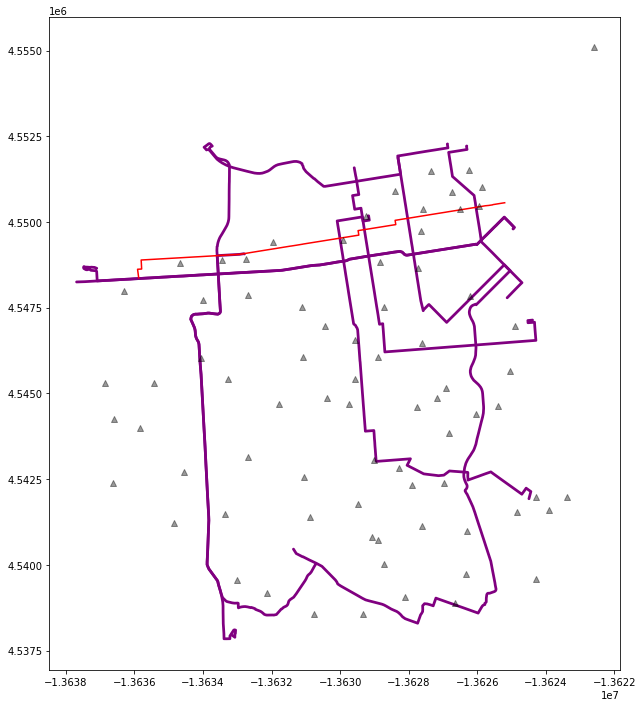

In [100]:
plt.figure(figsize=(12,12))
ax = plt.gca()
sc_df.plot(ax=ax, c='black', marker='^', zorder=50, alpha=0.4)
# small_buffered.plot(ax=ax, alpha=.5)
muni.head(1).plot(ax=ax, color='red')
#     muni.loc[6:6,:].plot(ax=ax, color='green')
small_buffered[small_buffered.geometry.overlaps(geom_b)].plot(ax=ax, color='purple')
# muni_poly.plot(ax=ax, color='red', alpha=0.3)

In [55]:
small_buffered.loc[6,'geometry'].overlaps(small_buffered.loc[8,'geometry'])

True

In [101]:
two_munis = pd.DataFrame()
for idx, row in small_buffered.iterrows():
    intersects = small_buffered[small_buffered.geometry.overlaps(row.geometry)].append(row)
    two_munis = two_munis.append(intersects.dissolve())

In [120]:
len(two_munis.drop_duplicates())

12

<AxesSubplot:>

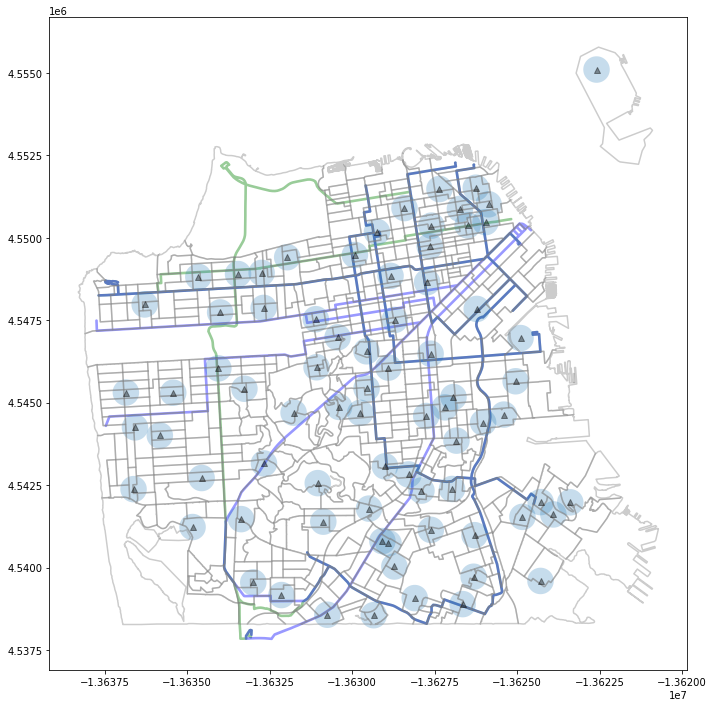

In [110]:
plt.figure(figsize=(12,12))
ax = plt.gca()
census.boundary.plot(ax=ax, color='gray', alpha=0.4)
# relevant_blocks.boundary.plot(ax=ax, color='gray', alpha=0.4)
sc_df.plot(ax=ax, c='black', marker='^', zorder=50, alpha=0.4)
two_munis.head(1).plot(ax=ax, color='green',alpha=.4)
two_munis.head(2).tail(1).plot(ax=ax, color='blue',alpha=.4)
# muni_poly.plot(ax=ax, color='red', alpha=0.3)
sch_buffered.plot(ax=ax, alpha=.25)

In [109]:
sch_buffered = sc_df.copy()
sch_buffered.geometry = sch_buffered.geometry.buffer(402)

In [117]:
sch1= sch_buffered.loc[1,'geometry']
two_munis[two_munis.geometry.overlaps(sch1)]

,geometry,PATTERN,PATTERNID,ROUTE_NAME,DIRECTION,PATTERN_TYPE,SUB_TYPE,PATTERN_VERSION,LINEABBR,SIGNID,SERVICE_CA,shape
0,"POLYGON ((-13633889.005 4541697.188, -13633906...",22 I F00,194100,22,I,F,0,0,022,130,Frequent,"MULTILINESTRING ((-122.38999 37.771107, -122.3..."
0,"POLYGON ((-13633055.522 4537897.215, -13633054...",14R I F10,194072,14R,I,F,1,0,014R,130,Rapid Bus,"MULTILINESTRING ((-122.46777 37.70593, -122.46..."
0,"POLYGON ((-13633888.144 4539918.052, -13633889...",14 I F00,194064,14,I,F,0,0,014,130,Frequent,"MULTILINESTRING ((-122.461235 37.706028, -122...."
0,"POLYGON ((-13633055.522 4537897.215, -13633054...",14 I F00,194064,14,I,F,0,0,014,130,Frequent,"MULTILINESTRING ((-122.461235 37.706028, -122...."
0,"POLYGON ((-13629299.532 4550072.017, -13629195...",1 I F00,193965,1,I,F,0,0,001,130,Frequent,"MULTILINESTRING ((-122.49313 37.7797, -122.493..."
0,"POLYGON ((-13633873.412 4541402.620, -13633873...",1 I F00,193965,1,I,F,0,0,001,130,Frequent,"MULTILINESTRING ((-122.49313 37.7797, -122.493..."
0,"POLYGON ((-13626088.315 4550479.920, -13626088...",1 I F00,193965,1,I,F,0,0,001,130,Frequent,"MULTILINESTRING ((-122.49313 37.7797, -122.493..."
0,"POLYGON ((-13626088.315 4550479.920, -13626088...",1 I F00,193965,1,I,F,0,0,001,130,Frequent,"MULTILINESTRING ((-122.49313 37.7797, -122.493..."
0,"POLYGON ((-13625929.984 4549483.816, -13625933...",14 I F00,194064,14,I,F,0,0,014,130,Frequent,"MULTILINESTRING ((-122.461235 37.706028, -122...."
0,"POLYGON ((-13625929.984 4549483.816, -13625933...",14 I F00,194064,14,I,F,0,0,014,130,Frequent,"MULTILINESTRING ((-122.461235 37.706028, -122...."


<AxesSubplot:>

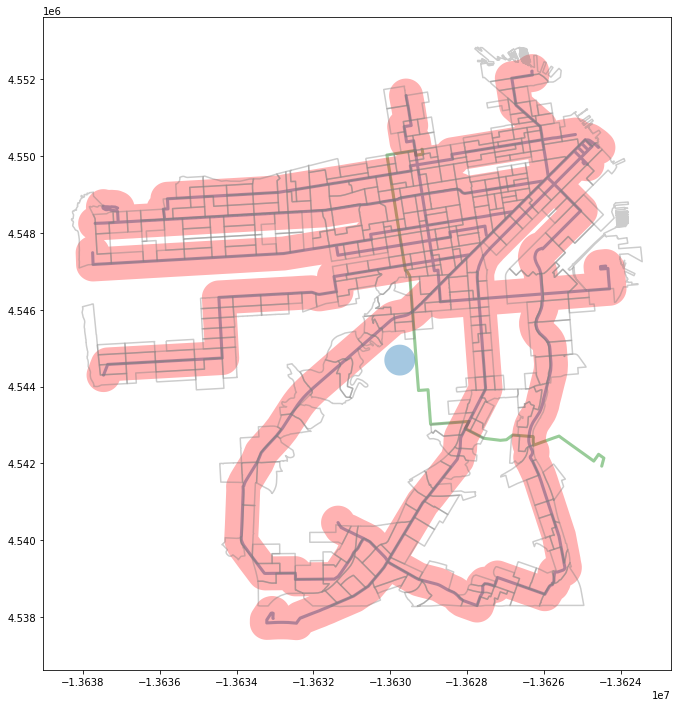

In [137]:
plt.figure(figsize=(12,12))
ax = plt.gca()
# census.boundary.plot(ax=ax, color='gray', alpha=0.4)
relevant_blocks.boundary.plot(ax=ax, color='gray', alpha=0.4)
sch_buffered.loc[1:1,'geometry'].plot(ax=ax, marker='^', zorder=50, alpha=0.4)
school_adjacent_routes = small_buffered[small_buffered.geometry.overlaps(sch1)]
school_adjacent_routes.plot(ax=ax, color='green',alpha=.4)
# print(school_adjacent_routes.dissolve().geometry[0])
intersects = small_buffered[small_buffered.geometry.overlaps(school_adjacent_routes.dissolve().geometry[0])].dissolve()
intersects.plot(ax=ax, alpha=.5)
intersects.geometry = intersects.geometry.buffer(402)
intersects.plot(ax=ax, alpha=.3, color='red')
# two_munis.head(2).tail(1).plot(ax=ax, color='blue',alpha=.4)
# # muni_poly.plot(ax=ax, color='red', alpha=0.3)
# sch_buffered.plot(ax=ax, alpha=.25)

In [135]:
census['block_lat'] = census.centroid.y
census['block_lon'] = census.centroid.x
census_centroid = census.copy()
census_centroid.geometry = [Point(xy) for xy in zip(census_centroid.block_lon, census_centroid.block_lat)]

In [136]:
relevant_blocks = census[census.index.isin(census_centroid.sjoin(intersects).index)]

In [142]:
muni_zones = {}
for idx, sch in sch_buffered.iterrows():
    school_adjacent_routes = small_buffered[small_buffered.geometry.overlaps(sch.geometry)]
    if len(school_adjacent_routes) == 0:
        print(sch.school_id)
        continue
    intersects = small_buffered[small_buffered.geometry.overlaps(school_adjacent_routes.dissolve().geometry[0])].dissolve()
    intersects.geometry = intersects.geometry.buffer(402)
    relevant_blocks = census[census.index.isin(census_centroid.sjoin(intersects).index)]
    muni_zones[sch.school_id] = list(relevant_blocks.BlockGroup)

453
481
485
497
507
521
539
544
562
575
589
614
625
670
676
680
722
723
782
801
830
842
862
910
912


In [145]:
muni_zones = {k: [int(x) for x in v] for k,v in muni_zones.items()}

In [147]:
len(muni_zones)

51

In [148]:
muni_zones.keys()

dict_keys([413, 420, 435, 449, 456, 476, 478, 479, 488, 490, 493, 505, 509, 513, 525, 537, 549, 569, 593, 603, 618, 638, 644, 650, 656, 664, 691, 714, 718, 724, 729, 735, 746, 750, 760, 786, 790, 796, 814, 816, 820, 823, 834, 838, 848, 859, 867, 872, 876, 909, 911])

In [149]:
with open('/Users/katherinementzer/Dropbox/SFUSD/two_muni_zones.yaml', 'w') as outfile:
    yaml.dump(muni_zones, outfile)

In [152]:
one_muni_zones = {}
for idx, sch in sch_buffered.iterrows():
    school_adjacent_routes = small_buffered[small_buffered.geometry.overlaps(sch.geometry)]
    if len(school_adjacent_routes) == 0:
        print(sch.school_id)
        continue
    school_adjacent_routes.loc[:,'geometry'] = school_adjacent_routes.geometry.buffer(402)
    relevant_blocks = census[census.index.isin(census_centroid.sjoin(school_adjacent_routes).index)]
    one_muni_zones[sch.school_id] = [int(x) for x in relevant_blocks.BlockGroup]

/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: Sett

453


/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: Sett

481
485


/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: Sett

497
507


/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


521


/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


539
544
562


/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


575
589


/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


614
625


/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: Sett

670
676
680


/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: Sett

722
723


/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: Sett

782


/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


801


/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: Sett

830


/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


842


/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


862


/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: Sett

910
912


/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [153]:
one_muni_zones

{413: [60750105002,
  60750108002,
  60750108003,
  60750110002,
  60750110003,
  60750111001,
  60750111002,
  60750112001,
  60750112002,
  60750112003,
  60750113001,
  60750113002,
  60750117001,
  60750117002,
  60750118001,
  60750119011,
  60750119022,
  60750120002,
  60750121001,
  60750121002,
  60750122011,
  60750122012,
  60750122021,
  60750123011,
  60750123012,
  60750123021,
  60750123022,
  60750124011,
  60750124012,
  60750124023,
  60750125012,
  60750125021,
  60750125022,
  60750131012,
  60750131021,
  60750133002,
  60750133003,
  60750133004,
  60750133005,
  60750134001,
  60750134002,
  60750134003,
  60750135001,
  60750135002,
  60750151001,
  60750151002,
  60750152001,
  60750152002,
  60750152003,
  60750153001,
  60750153002,
  60750154001,
  60750154002,
  60750154003,
  60750154004,
  60750154005,
  60750155001,
  60750155002,
  60750155003,
  60750156001,
  60750156003,
  60750157001,
  60750157003,
  60750158011,
  60750158012,
  60750159001,
  607

/Users/katherinementzer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


<AxesSubplot:>

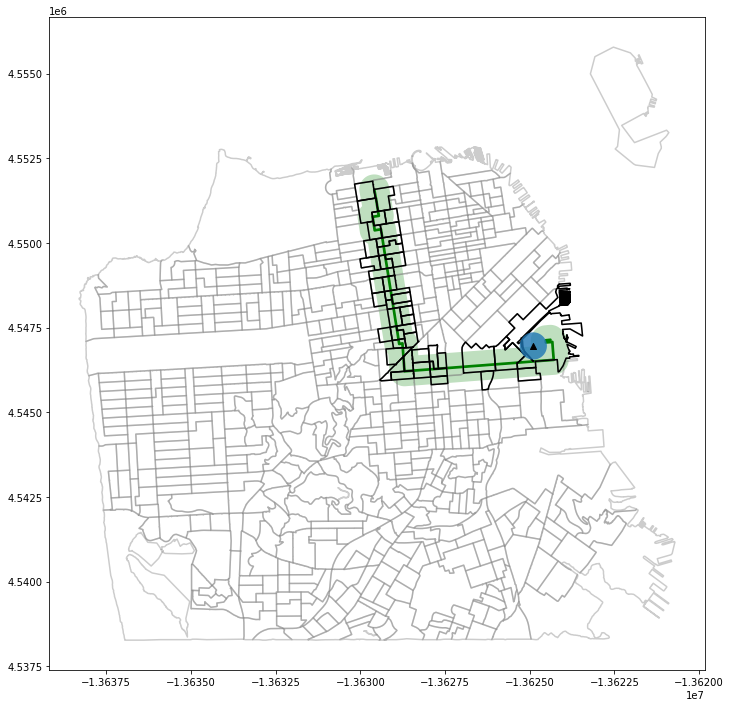

In [177]:
sch1 = sch_buffered.loc[sch_buffered.school_id == 909].geometry[72]
# print(sch1[72])
plt.figure(figsize=(12,12))
ax = plt.gca()
census.boundary.plot(ax=ax, color='gray', alpha=0.4)
# relevant_blocks.boundary.plot(ax=ax, color='gray', alpha=0.4)
sch_buffered.loc[sch_buffered.school_id == 909].plot(ax=ax, marker='^', zorder=50, alpha=0.8)
sc_df.loc[sc_df.school_id == 909].plot(ax=ax, marker='^', zorder=50,c='black')
school_adjacent_routes = small_buffered[small_buffered.geometry.overlaps(sch1)]
school_adjacent_routes.plot(ax=ax, color='green',alpha=1)
school_adjacent_routes.loc[:,'geometry'] = school_adjacent_routes.geometry.buffer(402)
# print(school_adjacent_routes)
school_adjacent_routes.plot(ax=ax, color='green',alpha=.25)
relevant_blocks = census[census.index.isin(census_centroid.sjoin(school_adjacent_routes).index)]
census[census.BlockGroup.isin(one_muni_zones[909])].boundary.plot(ax=ax, alpha=1, color='black')

In [169]:
with open('/Users/katherinementzer/Dropbox/SFUSD/one_muni_zones.yaml', 'w') as outfile:
    yaml.dump(one_muni_zones, outfile)

In [170]:
len(one_muni_zones)

51

In [172]:
for k, v in one_muni_zones.items():
    print(k, len(v), len(muni_zones[k]))

413 106 396
420 56 339
435 112 397
449 100 397
456 67 345
476 120 397
478 63 362
479 59 283
488 63 362
490 59 283
493 54 373
505 114 397
509 62 353
513 67 345
525 108 397
537 105 396
549 50 367
569 146 397
593 67 345
603 54 373
618 54 373
638 67 345
644 120 397
650 112 397
656 105 396
664 62 396
691 54 373
714 93 396
718 56 339
724 56 339
729 54 373
735 59 376
746 63 362
750 62 353
760 56 339
786 101 397
790 93 397
796 63 362
814 140 397
816 99 397
820 63 362
823 40 353
834 59 283
838 67 345
848 161 397
859 133 397
867 67 345
872 67 345
876 63 362
909 43 378
911 56 339
